## Predicting Loan through Linear Regression

Goal: Predict the amount of money made by a bank on a loan (money_made_inv). 
- Each row  corresponds to a loan
-  information about the loan applications, the applicants, and potential in-house evaluations of the applications. 
- Note that many of the non-numeric features are not standardized, so you should investigate both the training and test sets in order to determine how to encode them.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%b-%Y')

In [3]:
#parsing columns to date-time object

train = pd.read_csv("train.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse)
test = pd.read_csv("test.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse)
#display(pd.DataFrame({'Missing Values':train.isna().sum(),'Percentage':train.isna().sum()*100/train.shape[0]}))
#train.shape
train.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status'],
      dtype='object')

In [28]:
train.head()

,last_credit_pull_d2,id,money_made_inv,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,...,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status
0,2019-02-01,3819,-2787.380000,0,2,CT,21120.0,Individual,3662,86.1,...,3828.54,0,0,debt_consolidation,C1,36 months,0,65921,0.0,Verified
1,2016-11-01,3820,2.436708,0,3,CA,32400.0,Individual,2973,30.2,...,0.00,3,2,debt_consolidation,C1,36 months,0,17840,0.0,Not Verified
2,2018-04-01,3821,-3.773192,0,3,NY,30251.0,Individual,1983,46.2,...,0.00,0,0,debt_consolidation,B5,36 months,0,19829,0.0,Source Verified
3,2019-02-01,3822,-7951.970000,0,1,NJ,66976.0,Individual,1638,77.4,...,9665.27,0,0,debt_consolidation,C1,60 months,0,9830,0.0,Source Verified
4,2019-02-01,3823,-8058.760000,0,2,MO,125000.0,Individual,577,0.0,...,11358.24,0,0,debt_consolidation,A2,60 months,0,6924,0.0,Source Verified


## Data Exploration

Insights 
- from pair plot => obvious linear relationship `loan_amnt` & `out_prncp_inv` => money_made_inv
-  outcome variable `money_made_inv` is very skewed, with mean of -3417 and median of -4 -> we have skewed distribution & data inbalance
- `earliest_cr_line` -> change it to only years (so we can standardize?) 
- `emp_title`, skewed distribution, 964 categorical data, bin the ones with value count <= 2 into others (aggregate)
- `emp_length` -> ordinal data, change from string to numerical 
- `grade` and `subgrade` are basically the same categorical data, high multicollinearity, can be covered by each other. 
- `delinq_2yrs`-> bin it  0, 1, 2-5, 5+  (doesn't improve the model)

### Basic Measures

In [29]:
train.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status'],
      dtype='object')

In [30]:
train.money_made_inv.describe()

count     5778.000000
mean     -3416.502790
std       6635.846341
min     -38738.870000
25%      -4436.005000
50%         -4.114059
75%          1.872981
max      13197.780000
Name: money_made_inv, dtype: float64

In [31]:
#Check missing data: no missing data
train.isnull().sum()

last_credit_pull_d2     0
id                      0
money_made_inv          0
acc_now_delinq          0
acc_open_past_24mths    0
addr_state              0
annual_inc              0
application_type        0
avg_cur_bal             0
bc_util                 0
delinq_2yrs             0
delinq_amnt             0
dti                     0
earliest_cr_line        0
emp_length              1
emp_title               0
grade                   0
home_ownership          0
initial_list_status     0
int_rate                0
loan_amnt               0
mort_acc                0
num_sats                0
num_tl_120dpd_2m        0
num_tl_90g_dpd_24m      0
num_tl_30dpd            0
out_prncp_inv           0
pub_rec                 0
pub_rec_bankruptcies    0
purpose                 0
sub_grade               0
term                    0
tot_coll_amt            0
tot_cur_bal             0
total_rec_late_fee      0
verification_status     0
dtype: int64

#### Univariate EDA
Goal: know distribution for each potential predictors

In [32]:
train.term.value_counts

<bound method IndexOpsMixin.value_counts of 0       36 months
1       36 months
2       36 months
3       60 months
4       60 months
          ...    
5773    36 months
5774    60 months
5775    60 months
5776    60 months
5777    60 months
Name: term, Length: 5778, dtype: object>

In [33]:
train.emp_title.value_counts()

Teacher                           341
Manager                           331
Owner                             203
Registered Nurse                  151
Supervisor                        150
                                 ... 
Shareholder                         1
Senior Sales Executive              1
Air Traffic Control Specialist      1
bus operator                        1
Claims Supervisor                   1
Name: emp_title, Length: 964, dtype: int64

In [34]:
def transform(data):
    #cleaning term
    data['term'] = data['term'].str.replace('months', '')

    #cleaning emp_length
    #fill the only 1 na with 0 
    data['emp_length'] = data['emp_length'].str.replace('< 1 year', '0', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('years', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('year', '', regex=True)    
    data['emp_length'] = data['emp_length'].str.replace('+', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace(' ', '', regex=True)

    data['emp_length'] = data['emp_length'].fillna(0)
    
    data['emp_length'] = data['emp_length'].astype('int')

    ### binning employment title column '
    # count the value occurrences in column A
    value_counts = data['emp_title'].value_counts()
    # identify values with count <= 2
    values_to_change1 = value_counts[value_counts <= 2].index.tolist()
    # replace the identified values with a new value (e.g., -1)
    data.loc[data['emp_title'].isin(values_to_change1), 'emp_title'] = 'other1'
    
    values_to_change2 = value_counts[value_counts <= 5].index.tolist()
    data.loc[data['emp_title'].isin(values_to_change2), 'emp_title'] = 'other2'

transform(train)
transform(test)

In [35]:
train.emp_title.value_counts()

other1              798
other2              504
Teacher             341
Manager             331
Owner               203
                   ... 
SALES                 6
Regional Manager      6
Rn                    6
Security              6
Loan Officer          6
Name: emp_title, Length: 169, dtype: int64

In [36]:
#check predictors distribution
train.apply(lambda x: x.value_counts()).T.stack()


/var/folders/gb/7c0y49jn1r1cdlhcjrzqhm_w0000gn/T/ipykernel_31029/3133428368.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  train.apply(lambda x: x.value_counts()).T.stack()
/var/folders/gb/7c0y49jn1r1cdlhcjrzqhm_w0000gn/T/ipykernel_31029/3133428368.py:2: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects.
  train.apply(lambda x: x.value_counts()).T.stack()


last_credit_pull_d2  2019-02-01 00:00:00    3621.0
                     2019-01-01 00:00:00     209.0
                     2018-07-01 00:00:00     174.0
                     2018-10-01 00:00:00     158.0
                     2018-08-01 00:00:00     147.0
                                             ...  
total_rec_late_fee   98.42                     1.0
                     253.96                    1.0
verification_status  Source Verified        2488.0
                     Not Verified           1976.0
                     Verified               1314.0
Length: 31998, dtype: float64

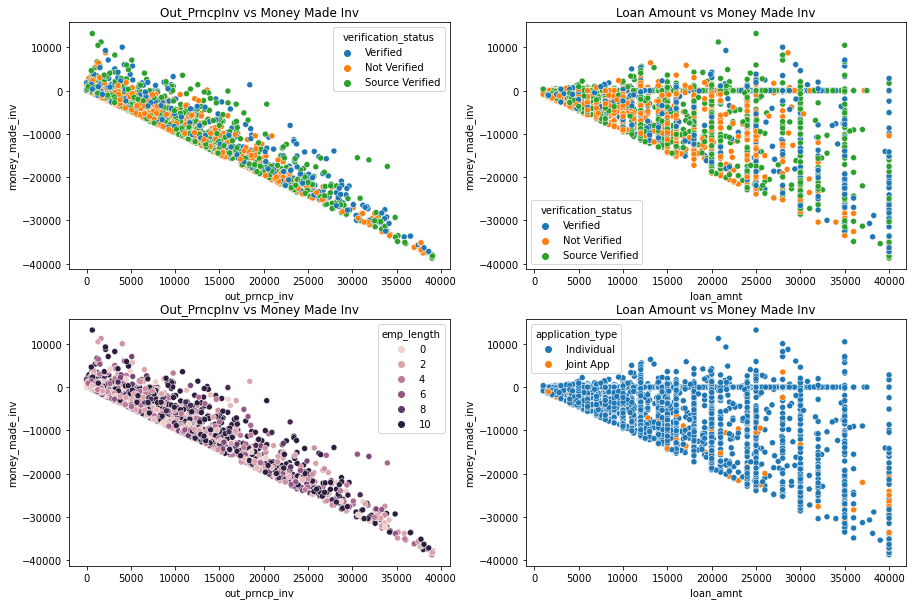

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 10))
sns.scatterplot(ax=axes[0,0], data = train, x = "out_prncp_inv", y = "money_made_inv", hue = "verification_status")
axes[0,0].set_title('Out_PrncpInv vs Money Made Inv');
sns.scatterplot(ax=axes[0,1], data = train, x = "loan_amnt", y = "money_made_inv", hue = "verification_status")
axes[0,1].set_title('Loan Amount vs Money Made Inv');

sns.scatterplot(ax=axes[1,0], data = train, x = "out_prncp_inv", y = "money_made_inv", hue = "emp_length")
axes[1,0].set_title('Out_PrncpInv vs Money Made Inv');

sns.scatterplot(ax=axes[1,1], data = train, x = "loan_amnt", y = "money_made_inv", hue = "application_type")
axes[1,1].set_title('Loan Amount vs Money Made Inv');

## Out Prncp Category Special Case
- Huge Imbalance in outprncp

0    3334
1    2444
Name: out_prncp_inv_categorical, dtype: int64

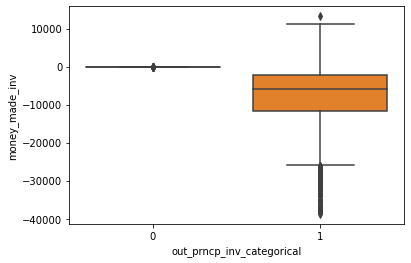

In [38]:
def out_prncp_tranform(data):
    data["out_prncp_inv_categorical"] = 0
    data.loc[data['out_prncp_inv']> 0, 'out_prncp_inv_categorical'] = 1

out_prncp_tranform(train)
out_prncp_tranform(test)

sns.boxplot(y = train['money_made_inv'], x = train['out_prncp_inv_categorical'])
display(train.out_prncp_inv_categorical.value_counts())

## Category Encoding (currently not implemented in model yet)

In [39]:
import category_encoders as ce

strType_l = []
for i in range(len(train.T)):
    if isinstance(train.iloc[0][i], str):
        strType_l.append(train.columns[i])

display(strType_l)

target_l =[]
for i in strType_l:
    if len(train[i].unique()) > 4:
        target_l.append(i)

#display(target_l)

# Create the encoder
target_enc = ce.TargetEncoder(cols = target_l)
target_enc.fit(train[target_l], train['out_prncp_inv'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = train.join(target_enc.transform(train[target_l]).add_suffix('_target'))
train_TE.columns

# plt.figure(figsize = (17,17), dpi = 200)
# sns.heatmap(train_TE.corr(), annot = True, fmt = ".1f", cmap = "YlGnBu")


['addr_state',
 'application_type',
 'earliest_cr_line',
 'emp_title',
 'grade',
 'home_ownership',
 'initial_list_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status',
       'out_prncp_inv_categorical', 'addr_state_target',
       'earliest_cr_line_target', 'emp_title_target', 'grade_target',
       'purpose_target', 'sub_grade_target'],
      dtype='object')

### Model1:
- out_prncp * loan_amnt
- loan_amnt & term
- outprncp * term
- I(out_prncp_inv)**2
- int_rate
- out_prncp * int_rate
- out_prncp_categorical * term

In [40]:
model = smf.ols(formula = 'money_made_inv~out_prncp_inv*loan_amnt+loan_amnt*term+out_prncp_inv*term+I(out_prncp_inv**2)+int_rate+int_rate*out_prncp_inv+int_rate*term+out_prncp_inv_categorical*term', data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         money_made_inv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.437e+04
Date:                Sat, 25 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:05:37   Log-Likelihood:                -46669.
No. Observations:                5778   AIC:                         9.336e+04
Df Residuals:                    5765   BIC:                         9.345e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              -218.0618     46.797     -4.660      0.000    -309.802    -126.321
term[T.60 ]                           -1626.8379    110.598    -14.709      0.000   -1843.652   -1410.024
out_prncp_inv                            -1.3216      0.008   -166.764      0.000      -1.337      -1.306
out_prncp_inv:term[T.60 ]                -0.1093      0.006    -19.102      0.000      -0.121      -0.098
loan_amnt                                 0.0079      0.002      4.578      0.000       0.005       0.011
loan_amnt:term[T.60 ]                     0.0500      0.003     14.669      0.000       0.043       0.057
out_prncp_inv:loan_amnt                2.599e-05   3.03e-07     85.645      0.000    2.54e-05    2.66e-05
I(out_prncp_inv ** 2)                 -2.383e-05   3.43e-07    -69.424      0.000   -2.45e-05   -2.32e-05
int_rate                                  9.8488      3.120      3.157      0.002       3.732      15.965
int_rate:term[T.60 ]                     28.3306      5.098      5.558      0.000      18.337      38.324
int_rate:out_prncp_inv                    0.0135      0.000     43.531      0.000       0.013       0.014
out_prncp_inv_categorical              1393.6623     41.414     33.652      0.000    1312.475    1474.850
out_prncp_inv_categorical:term[T.60 ]  3658.5658     86.023     42.530      0.000    3489.929    3827.203
==============================================================================
Omnibus:                     2849.513   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111176.318
Skew:                           1.684   Prob(JB):                         0.00
Kurtosis:                      24.224   Cond. No.                     3.87e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Potential Feature Engineering:

In [41]:
import re

def monthly_payment(principle, rate, time):
    '''
    https://www.mymove.com/mortgage/mortgage-calculation/
    '''
    exponential_term = np.power(1 + rate, time)

    return principle * rate * exponential_term / (exponential_term - 1)

def remaining_time(monthly_payment, int_rate, out_prncp_inv):

    '''
    https://finance.zacks.com/figure-out-much-left-mortgage-9287.html
    :param monthly_payment:
    :param int_rate:
    :param out_prncp_inv:
    :return:
    '''

    return -np.log(1 - out_prncp_inv * int_rate / monthly_payment) / np.log(1 + int_rate)

def pipeline(df: pd.DataFrame):

    regex = re.compile("[\d]+")

    df['term in months'] = df['term'].apply(lambda x: int(regex.findall(x)[0]))
    df['monthly interest rate'] = df['int_rate'] / 100 / 12

    df['monthly_payment'] = df[['loan_amnt', 'monthly interest rate', 'term in months']].apply(
        lambda x: monthly_payment(x[0], x[1], x[2]), axis=1)

    df['paid_princp_inv'] = df['loan_amnt'] - df['out_prncp_inv']
    df['duration'] =  df[['monthly_payment', 'monthly interest rate', 'paid_princp_inv']].apply(
        lambda x: remaining_time(x[0], x[1], x[2]), axis=1)

    df['remaining time'] = df[['monthly_payment', 'monthly interest rate', 'out_prncp_inv']].apply(
        lambda x: remaining_time(x[0], x[1], x[2]), axis=1)

    # Simple will be paid
    df.loc[~np.isinf(df['remaining time']), 'will be paid'] = df.loc[~np.isinf(
        df['remaining time']), 'remaining time'] * df.loc[~np.isinf(
        df['remaining time']), 'monthly_payment']

    df['will be paid'].fillna(0, inplace=True)

    # adjusted with interest rate
    df['remaining time to end'] = df['term in months'] - df['duration']
    return df

In [42]:
train_feature = pipeline(train)
test_feature = pipeline(test)

display(train_feature.shape)
display(test_feature.shape)

(5778, 45)

(3818, 44)

In [1]:
train.columns

NameError: name 'train' is not defined

## Predictions based on Model1

In [43]:
#adding target_encoding to test_dataset (model 1 doesn't use this yet)
target_l =[]
for i in strType_l:
    if len(train[i].unique()) > 4:
        target_l.append(i)

# Create the encoder
target_enc = ce.TargetEncoder(cols = target_l)
target_enc.fit(test[target_l], test['out_prncp_inv'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
test_TE = test.join(target_enc.transform(test[target_l]).add_suffix('_target'))
#test_TE.columns
test_TE.shape

(3818, 50)

In [44]:
prediction_train = model.predict(train)
print(np.sqrt(((train.money_made_inv - prediction_train)**2).mean()))

prediction_s = model.predict(test)

prediction_s.shape

779.0434834926717


(3818,)

In [45]:
train_feature.columns

Index(['last_credit_pull_d2', 'id', 'money_made_inv', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status',
       'out_prncp_inv_categorical', 'term in months', 'monthly interest rate',
       'monthly_payment', 'paid_princp_inv', 'duration', 'remaining time',
       'will be paid', 'remaining time to end'],
      dtype='object')

## Prediction Based on Model 2 (with feature engineering)

In [46]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

X = train_feature[['out_prncp_inv', 'int_rate', 'monthly_payment', 'remaining time', 'remaining time to end', 'out_prncp_inv_categorical']]
y = train_feature['money_made_inv'].reset_index(drop=True)

poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X = poly.fit_transform(X)
X = pd.DataFrame(data=X, columns = poly.get_feature_names_out())

display(X.shape)
display(X.head(3))

model = sm.OLS(y, X).fit()
model.summary()

prediction_train_feat = model.predict(X) 
print(np.sqrt(((train.money_made_inv - prediction_train_feat)**2).mean()))

(5778, 83)

,out_prncp_inv,int_rate,monthly_payment,remaining time,remaining time to end,out_prncp_inv_categorical,out_prncp_inv^2,out_prncp_inv int_rate,out_prncp_inv monthly_payment,out_prncp_inv remaining time,...,remaining time^3,remaining time^2 remaining time to end,remaining time^2 out_prncp_inv_categorical,remaining time remaining time to end^2,remaining time remaining time to end out_prncp_inv_categorical,remaining time out_prncp_inv_categorical^2,remaining time to end^3,remaining time to end^2 out_prncp_inv_categorical,remaining time to end out_prncp_inv_categorical^2,out_prncp_inv_categorical^3
0,3828.54,12.62,234.578483,17.99982,2.134040e+01,1.0,1.465772e+07,48316.1748,898093.104105,68913.031449,...,5831.825191,6914.152247,323.993526,8197.348125,384.123407,17.99982,9.718692e+03,455.412779,21.340403,1.0
1,0.00,11.99,537.994448,-0.00000,7.105427e-15,0.0,0.000000e+00,0.0000,0.000000,-0.000000,...,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.00000,3.587324e-43,0.000000,0.000000,0.0
2,0.00,11.49,316.524007,-0.00000,-1.421085e-14,0.0,0.000000e+00,0.0000,0.000000,-0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.00000,-2.869859e-42,0.000000,-0.000000,0.0


255.08429471718284


In [47]:
test_X = test_feature[['out_prncp_inv', 'int_rate', 'monthly_payment', 'remaining time', 'remaining time to end', 'out_prncp_inv_categorical']]
poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
test_X = poly.fit_transform(test_X)
test_X = pd.DataFrame(data=test_X, columns = poly.get_feature_names_out())

test_X.head(2)

,out_prncp_inv,int_rate,monthly_payment,remaining time,remaining time to end,out_prncp_inv_categorical,out_prncp_inv^2,out_prncp_inv int_rate,out_prncp_inv monthly_payment,out_prncp_inv remaining time,...,remaining time^3,remaining time^2 remaining time to end,remaining time^2 out_prncp_inv_categorical,remaining time remaining time to end^2,remaining time remaining time to end out_prncp_inv_categorical,remaining time out_prncp_inv_categorical^2,remaining time to end^3,remaining time to end^2 out_prncp_inv_categorical,remaining time to end out_prncp_inv_categorical^2,out_prncp_inv_categorical^3
0,0.0,17.57,251.600890,-0.0,-2.131628e-14,0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-9.685775e-42,0.0,-0.0,0.0
1,0.0,8.24,452.839683,-0.0,1.421085e-14,0.0,0.0,0.0,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,2.869859e-42,0.0,0.0,0.0


In [48]:
prediction_s_f = model.predict(test_X)
prediction_s_f.shape

(3818,)

## Formatting & Saving to CSV

In [49]:
# prediction = pd.DataFrame(prediction_s, columns=['Predicted'])
prediction = pd.DataFrame(prediction_s_f, columns=['Predicted'])
prediction.index = test.id
prediction.index.name = 'id'

prediction.shape

(3818, 1)

In [50]:
prediction.to_csv(r'/Users/juliachu/Dropbox/Northwestern/2022-2023/2.WQ/STAT 303-2/kaggle/Loan_Amount/Linear/prediction.csv', header=True, index=True)